# Image Analyzer 
## Example using PySpark and Scikit-learn
* Follow the steps in <a href="https://github.com/ContinuumIO/image-analyzer/blob/master/run_helper.sh">run_helper.sh</a>, while using the default hdfs file naming in <a href="https://github.com/ContinuumIO/image-analyzer/blob/master/config.yaml">config.yaml</a>
* Then run each ipython notebook cell below to look at results
* If the notebook examples do not work, check your config.yaml against the config shown at the bottom of the notebook
* This notebook uses the example faces image <a href="http://cswww.essex.ac.uk/mv/allfaces/faces94.html">data set of Dr. Libor Spacek</a>

In [1]:
%env JAVA_HOME=/usr/lib/jvm/java-7-openjdk-amd64
%matplotlib inline
from __future__ import print_function, division
from pyspark import SparkConf
from pyspark import SparkContext 
from StringIO import StringIO
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

conf = SparkConf()
conf.set('spark.executor.instances', 10)
sc = SparkContext()


env: JAVA_HOME=/usr/lib/jvm/java-7-openjdk-amd64


### 'example' below shows an output for one image or an image selection
#### These measurements are done for training and candidate images
#### On each training or candidate image, the measurements may also be applied to patches
#### The relevant code for this is <a href="https://github.com/ContinuumIO/image-analyzer/blob/master/map_each_image.py">map_each_image.py.</a> <i> (The function "example" in map_each_image.py can do these measurements locally on an image file.)</i>
* Kmeans centroids
* Histogram
* Perceptive hashes (abbrev.)
* Ward cluster hashes (abbrev.) (hashing the output of the function seen in <a href="http://scikit-learn.org/stable/auto_examples/cluster/plot_lena_ward_segmentation.html">this scikit demo</a>
* Prinicipal components

In [2]:
example = sc.pickleFile('hdfs:///t1/map_each_image/measures').take(1)[0]
print("Keys:", example[1].keys())
print("Centroids in 1 image flattened:", example[1]['cen'])
print("Histogram flattened:", example[1]['histo'])
print("Perceptive hash (abbrev.):", example[1]['phash'][:5])
print("Ward cluster hash (abbrev.):", example[1]['ward'][:5])
print('PCA factors and variance', example[1]['pca_fac'], example[1]['pca_var'])

Keys: ['cen', 'pca_var', 'meta', 'phash', 'histo', 'ward', 'pca_fac', 'id']
Centroids in 1 image flattened: [ 0.97923583  0.75995809  0.78396827  0.28556019  0.2307422   0.19607088
  0.55954945  0.43983251  0.47005937  0.05438971  0.05043375  0.04051252
  0.47617429  0.64561862  0.26225725  0.74394125  0.55301815  0.61982757
  0.40564099  0.33140001  0.32744032  0.16533358  0.1298058   0.11420634]
Histogram flattened: [ 0.03504902  0.10292386  0.32177243  0.50134736  0.99531692  0.03497709
  0.08765319  0.26445279  0.51220495  0.77945971  0.02536765  0.07102249
  0.22428735  0.40639919  0.80535847]
Perceptive hash (abbrev.): [-7658543951853735311, 6229875750333130541, 7224834377505029880]
Ward cluster hash (abbrev.): (8871311509876279992, 1304539426038721001, 8871311509876279992, 1304539426038721001, 1304539426038721001)
PCA factors and variance [ -1.46830671  -1.19930027  -1.19243962   0.55415058  -7.7928679
   7.1553523   16.29226312  -8.97422908 -11.03556408] [ 0.19935576  0.0089098

### Based on the data above for each image, a kmeans algorithm is run for all training images
#### The kmeans algorithm also tracks the most common perceptive hashes and ward cluster hashes
#### <a href="https://github.com/ContinuumIO/image-analyzer/blob/master/image_mapper.py">image_mapper.py</a> has the iterative kmeans loop on all images
* This shows cluster to hash lookups

In [3]:
print('Kmeans cluster to perceptive hash')
pprint(sc.pickleFile("hdfs:///t1/km/cluster_to_phash").take(2))

print('Kmeans cluster to Ward cluster hash')
pprint(sc.pickleFile("hdfs:///t1/km/cluster_to_phash").take(2))

Kmeans cluster to perceptive hash
[(0, (-7658543951853735311, 6229875750333130541)),
 (0, (6566855675341677916, 1138429227048884141))]
Kmeans cluster to Ward cluster hash
[(0, (-7658543951853735311, 6229875750333130541)),
 (0, (6566855675341677916, 1138429227048884141))]


### Also we save the inverse mappings of hash to cluster
#### This provides several ways to search for images by hash or kmeans cluster
#### In <a href="https://github.com/ContinuumIO/image-analyzer/blob/master/config.yaml">config.yaml</a>, see the kmeans_output dictionary that controls which lookup tables are created

In [4]:
print('Perceptive hash to kmeans cluster')
pprint(sc.pickleFile("hdfs:///t1/km/phash_to_cluster").take(2))

print("Ward cluster hash to kmeans cluster")
pprint(sc.pickleFile("hdfs:///t1/km/ward_to_cluster").take(2))

Perceptive hash to kmeans cluster
[((-7658543951853735311, 6229875750333130541), 0),
 ((6566855675341677916, 1138429227048884141), 0)]
Ward cluster hash to kmeans cluster
[(8871311509876279992, 0), (1304539426038721001, 0)]


### Hash counts in kmeans clusters
#### A dictionary for each kmeans cluster counts the most common N hashes per cluster
* This shows the top ward cluster hashes in kmeans cluster with index 0

In [6]:
clust0_ward = sc.pickleFile('hdfs:////t1/km/ward_unions').take(1)[0]
pprint({k:v for k,v in clust0_ward.items()})

{-8107382044459025544: 1,
 -7886419941714386489: 1,
 -7051117696397802753: 1,
 -6371097860695599930: 2,
 -6017733988929168898: 1,
 -5819890651931820116: 1,
 -5130029528390688653: 1,
 -4536042774558666965: 1,
 -2699164510210933549: 2,
 -2098177597065484460: 1,
 -1502527958492523552: 1,
 -485006089207924609: 1,
 1304539426038721001: 1,
 1371740626673703937: 1,
 3238841164580314816: 1,
 3466675275644008814: 2,
 3646278414086176633: 1,
 4057885539768507463: 1,
 7872854186025934548: 1,
 8871311509876279992: 2}


### Hash counts in kmeans clusters (continued)
* This shows some perceptive hash counts in kmeans cluster 0
* (With the settings in <a href="https://github.com/ContinuumIO/image-analyzer/blob/master/config.yaml">config.yaml</a> for perceptive hash bits, the perceptive hashes are more specific than ward cluster hashes)

In [7]:
cluster_0 = sc.pickleFile('hdfs:////t1/km/phash_unions').take(1)[0]
pprint(cluster_0.items()[:10])

[(-4802540074043417654, 1),
 (-8857875119730360372, 1),
 (-2075127586002862190, 1),
 (6797730866190135150, 1),
 (317378855003762157, 1),
 (-8334591071966581422, 1),
 (8256684137587089267, 1),
 (-8878562443604476679, 1),
 (-3360695863063161718, 1)]


### Using joins to finally get a matching image name
#### These examples are ward hash to image key and perceptive hash to image key mappings

In [8]:
print('ward_to_key\n')
pprint(sc.pickleFile('hdfs:///t1/km/ward_to_key').take(2))
print('\n\nphash_to_key\n')
pprint(sc.pickleFile('hdfs:///t1/km/phash_to_key').take(2))

ward_to_key

[(8871311509876279992,
  'hdfs://ip-10-7-180-199:9000/imgs/femaleanpageanpage.6.jpg'),
 (1304539426038721001,
  'hdfs://ip-10-7-180-199:9000/imgs/femaleanpageanpage.6.jpg')]


phash_to_key

[((-7658543951853735311, 6229875750333130541),
  'hdfs://ip-10-7-180-199:9000/imgs/femaleanpageanpage.6.jpg'),
 ((6566855675341677916, 1138429227048884141),
  'hdfs://ip-10-7-180-199:9000/imgs/femalekaknigkaknig.2.jpg')]


### Joins lead to a number of potentially matching images
* The example below shows the number of ward hash chunks matching a candidate
* The candidate has a path name /fuzzy/
* The others are the originals in /imgs/

In [5]:
ward_matches = sc.pickleFile('hdfs:///t1/candidates/c1/ward_to_key_counts')
phash_matches = sc.pickleFile('hdfs:///t1/candidates/c1/phash_to_key_counts')
print("Ward")
wm = ward_matches.take(40)
pprint(wm[:2])


Ward
[('hdfs://ip-10-7-180-199:9000/fuzzy/malemberdomberdo.7.jpg',
  (('hdfs://ip-10-7-180-199:9000/imgs/malemberdomberdo.7.jpg', 1248),
   {'hdfs://ip-10-7-180-199:9000/imgs/malemberdomberdo.7.jpg': 1248})),
 ('hdfs://ip-10-7-180-199:9000/fuzzy/malecshubbcshubb.15.jpg',
  (('hdfs://ip-10-7-180-199:9000/imgs/malecshubbcshubb.15.jpg', 1664),
   {'hdfs://ip-10-7-180-199:9000/imgs/femalekaknigkaknig.2.jpg': 832,
    'hdfs://ip-10-7-180-199:9000/imgs/malecshubbcshubb.15.jpg': 1664,
    'hdfs://ip-10-7-180-199:9000/imgs/maledagrandagran.1.jpg': 832,
    'hdfs://ip-10-7-180-199:9000/imgs/malejagrifjagrif.18.jpg': 416}))]


#### Joins and matches continued
* This example shows more specificity in the perceptive hashes than ward hashes

In [3]:
phash_matches = sc.pickleFile('hdfs:///t1/candidates/c1/phash_to_key_counts').take(5)
pprint(phash_matches)


[]


Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/malemberdomberdo.7.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/malemberdomberdo.7.jpg


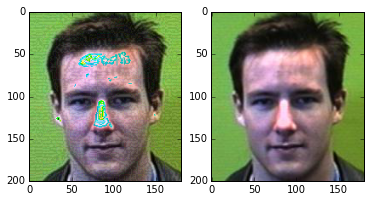

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/malecshubbcshubb.15.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/malecshubbcshubb.15.jpg


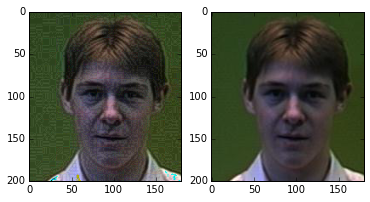

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/femaleanpageanpage.6.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/femaleanpageanpage.6.jpg


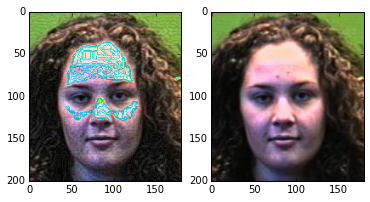

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/malespletcspletc.16.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/male93384549338454.4.jpg


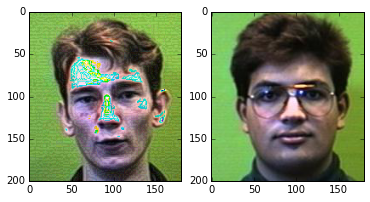

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/malenahaignahaig.15.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/malenahaignahaig.15.jpg


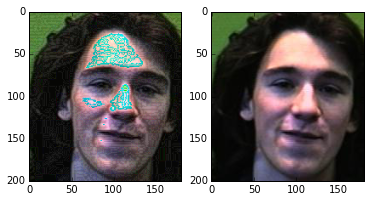

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/maledagrandagran.1.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/maledagrandagran.1.jpg


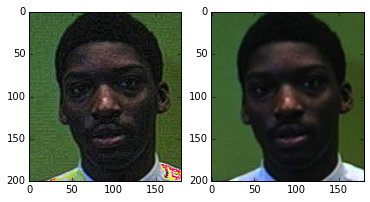

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/malermcollrmcoll.3.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/femaleanpageanpage.6.jpg


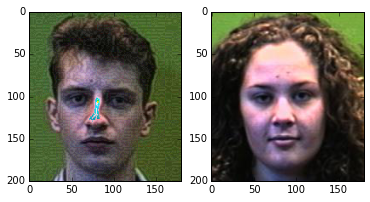

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/male93384549338454.4.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/male93384549338454.4.jpg


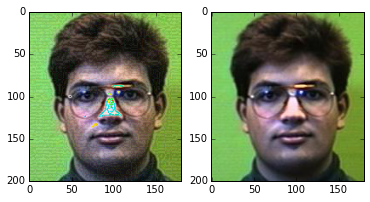

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/maledmwestdmwest.20.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/malegsreasgsreas.12.jpg


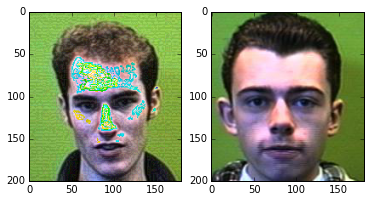

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/malemjhansmjhans.14.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/malemjhansmjhans.14.jpg


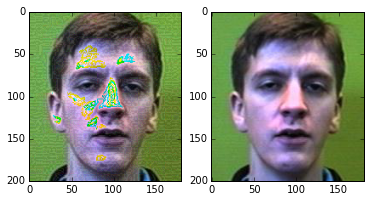

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/malesmrobbsmrobb.6.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/malesmrobbsmrobb.6.jpg


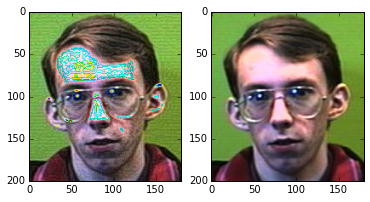

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/malegsreasgsreas.12.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/malenahaignahaig.15.jpg


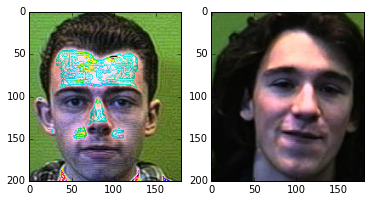

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/malejagrifjagrif.18.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/malejagrifjagrif.18.jpg


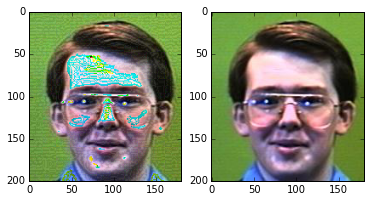

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/maleajonesajones.15.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/maledagrandagran.1.jpg


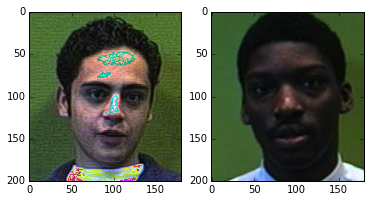

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/malelejnnolejnno.1.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/femaleanpageanpage.6.jpg


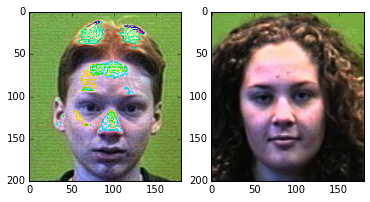

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/malenjmoornjmoor.16.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/malenjmoornjmoor.16.jpg


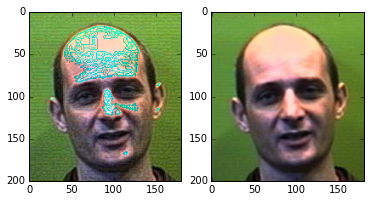

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/malejlemonjlemon.17.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/male93384979338497.11.jpg


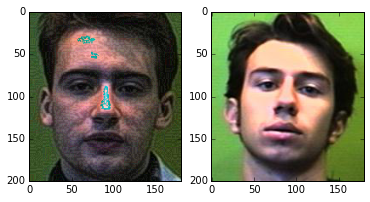

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/malegjherogjhero.19.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/malegjherogjhero.19.jpg


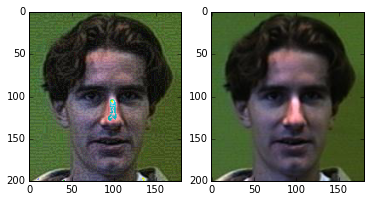

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/femalekaknigkaknig.2.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/malejagrifjagrif.18.jpg


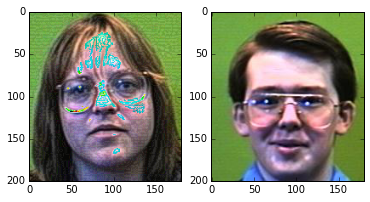

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/male93384979338497.11.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/male93384549338454.16.jpg


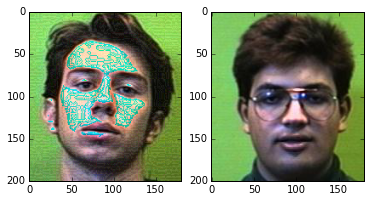

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/malemjhansmjhans.5.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/malemjhansmjhans.5.jpg


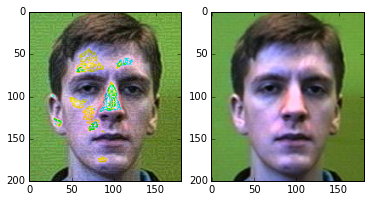

Candidate (fuzzy) hdfs://ip-10-7-180-199:9000/fuzzy/malestaffmichaelmichael.1.jpg
Matched (original) hdfs://ip-10-7-180-199:9000/imgs/male93384549338454.16.jpg


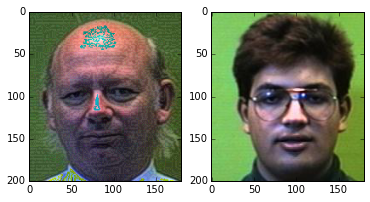

In [4]:
def load_image(image):
    """Load one image, where image = (key, blob)"""
    from StringIO import StringIO
    from PIL import Image
    img_quads = []
    img = Image.open(StringIO(image[1]))
    return  image[0], np.asarray(img, dtype=np.uint8)
for p in wm:
    cname, candidate = load_image(sc.binaryFiles(p[0]).collect()[0])
    mname, matched = load_image(sc.binaryFiles(p[1][0][0]).collect()[0])
    print("Candidate (fuzzy)", cname)
    plt.subplot(1,2,1)
    plt.imshow(candidate)
    print("Matched (original)",mname)        
    plt.subplot(1,2,2)
    plt.imshow(matched)
    plt.show()


#### 'config' below shows the yaml config file loaded for this example

In [2]:
config = {'actions': ['map_each_image', 'kmeans', 'find_similar'],
 'candidate_batch': 'c1',
 'candidate_has_mapped': False,
 'candidate_measures_spec': '/t1/candidates/c1/measures',
 'candidate_spec': '/fuzzy/*',
 'example_data': '/imgs/',
 'fuzzy_example_data': '/fuzzy/',
 'in_memory_set_len': 8000000,
 'input_spec': '/imgs/*',
 'kmeans_group_converge': 10000,
 'kmeans_output': {'cluster_to_flattened': True,
                   'cluster_to_key': True,
                   'cluster_to_phash': True,
                   'cluster_to_ward': True,
                   'flattened_to_cluster': True,
                   'flattened_to_key': True,
                   'flattened_to_phash': True,
                   'key_to_cluster': True,
                   'key_to_phash': True,
                   'phash_to_cluster': True,
                   'phash_to_flattened': True,
                   'phash_to_key': True,
                   'ward_to_cluster': True,
                   'ward_to_key': True},
 'kmeans_sample': 2000,
 'maxIterations': 15,
 'max_iter_group': 5,
 'n_clusters': 5,
 'n_clusters_group': 10,
 'patch': {'max_patches': 5,
           'random_state': 0,
           'window_as_fraction': [0.5, 0.5]},
 'phash_bits': 4096,
 'phash_chunk_len': 2,
 'quantiles': [1, 2, 5, 15, 25, 50, 75, 85, 95, 98, 99],
 'search_rounds': 1,
 'search_sample_step': 100,
 'test_name': 't1',
 'ward_clusters': 20,
 'ward_x_down': 128,
 'x_down': 256}
               